# Exploração do Notebook 5

Importando os pacotes necessários:

In [1]:
from astropy.io import fits
import os
import numpy as np
from astropy.table import Table, Column, MaskedColumn
import matplotlib.pyplot as plt
import pandas as pd

Abrindo o fits:

In [2]:
dados_dir = 'specz_catalog_XIIIecbpf.fits'

hdul = fits.open(dados_dir, ignore_missing_end=True) 
data = hdul[1].data # table extensions can't be the first extension, so there's a dummy image extension at 0
cat_table = Table(data)
cols=cat_table.columns
# print(data)
print(cols)

<TableColumns names=('ra','dec','class','z','zErr','petroMag_u','petroMagErr_u','petroMag_g','petroMagErr_g','petroMag_r','petroMagErr_r','petroMag_i','petroMagErr_i')>


Gerando o dataframe e arrumando algumas entradas 'ruins':

In [3]:
df = cat_table.to_pandas()

df = df.drop(df[df['class']!= 'GALAXY'].index) #dropando as estrelas. 
df = df.drop('class', axis=1) #dropando a coluna class.
df = df.replace(['null    ', 'null        ', 'null        '], np.NaN) #substituindo null por NaN.
df = df.astype(float) #convertendo as entradas da tabela para float.

df[df['petroMag_u'] < 0] = np.NaN #filtrando magnitudes negativas.
df[df['petroMag_g'] < 0] = np.NaN #filtrando magnitudes negativas
df[df['petroMag_r'] < 0] = np.NaN #filtrando magnitudes negativas.
df[df['petroMag_i'] < 0] = np.NaN #filtrando magnitudes negativas.
df = df.drop(df[df.z == np.NaN].index) #dropando quaisquer linhas que tenham z == np.NaN.
df = df.drop(df[df.petroMag_u == np.NaN].index) #dropando quaisquer linhas que tenham petroMag_x == np.NaN.
df = df.drop(df[df.petroMag_g == np.NaN].index) #dropando quaisquer linhas que tenham petroMag_x == np.NaN.
df = df.drop(df[df.petroMag_r == np.NaN].index) #dropando quaisquer linhas que tenham petroMag_x == np.NaN.
df = df.drop(df[df.petroMag_i == np.NaN].index) #dropando quaisquer linhas que tenham petroMag_x == np.NaN.


df

,ra,dec,z,zErr,petroMag_u,petroMagErr_u,petroMag_g,petroMagErr_g,petroMag_r,petroMagErr_r,petroMag_i,petroMagErr_i
0,146.622820,-0.951385,0.371128,0.000069,22.40671,0.991268,20.32166,0.091261,18.62304,0.030898,18.05202,0.036655
1,146.592720,-0.760256,0.064959,0.000009,19.03327,0.089179,17.49610,0.010818,16.91567,0.010075,16.50206,0.010200
2,146.910800,-0.074559,0.242272,0.000086,20.18482,0.296445,19.53431,0.088922,18.03267,0.033880,17.43746,0.045125
3,146.448310,-0.713400,0.114698,0.000008,18.94475,0.047213,17.98683,0.009779,17.45100,0.009234,17.02182,0.008779
4,146.788470,-0.310658,0.056562,0.000015,20.73877,0.480484,18.73327,0.036661,18.14503,0.033823,17.86618,0.039255
...,...,...,...,...,...,...,...,...,...,...,...,...
175915,15.770648,-0.373149,0.064814,0.000032,19.45067,0.217810,18.14903,0.035346,17.76802,0.034484,17.40179,0.040466
175916,16.005106,-0.855950,0.065073,0.000007,18.20492,0.051291,17.21942,0.010603,16.86439,0.008551,16.60081,0.013409
175917,15.651509,-0.637366,0.191312,0.000035,20.34421,0.248613,18.83951,0.031803,17.65709,0.016823,17.13594,0.015663
175918,15.866415,-1.159094,0.137276,0.000023,19.12054,0.086672,17.90217,0.016173,17.00707,0.009946,16.62113,0.011164


Salvando em um arquivo fits e abrindo o novo arquivo:

In [4]:
new_table1 = Table.from_pandas(df)
tabela_exercicio_1 = os.path.join("arquivosgerados",'NewLegacyCatalog.fits')
hdu = fits.BinTableHDU(data=new_table1)
hdu.writeto(tabela_exercicio_1, overwrite=True)

hdul = fits.open("arquivosgerados/NewLegacyCatalog.fits", ignore_missing_end=True)

data = hdul[1].data # table extensions can't be the first extension, so there's a dummy image extension at 1
cat_table = Table(data)
cols=cat_table.columns
print(cat_table)
print(cols)

    ra        dec          z      ... petroMagErr_r petroMag_i petroMagErr_i
--------- ------------ ---------- ... ------------- ---------- -------------
146.62282  -0.95138526  0.3711277 ...    0.03089815   18.05202    0.03665525
146.59272  -0.76025604 0.06495924 ...    0.01007535   16.50206    0.01019981
 146.9108 -0.074559356  0.2422717 ...    0.03387981   17.43746    0.04512536
146.44831  -0.71339967  0.1146981 ...   0.009233744   17.02182   0.008778921
146.78847  -0.31065752 0.05656198 ...    0.03382286   17.86618    0.03925543
146.09369  -0.79308773 0.06758517 ...   0.005180169   15.43335   0.004949708
146.09369  -0.79308773 0.06762055 ...   0.005180169   15.43335   0.004949708
      ...          ...        ... ...           ...        ...           ...
16.063257    -1.114314 0.01798435 ...   0.004130061   14.40654    0.00436022
15.844699  -0.67906213  0.2059941 ...    0.01499067   18.41356    0.01536485
15.770648  -0.37314851  0.0648139 ...    0.03448401   17.40179    0.04046607

Plotando as magnitudes:

<function matplotlib.pyplot.show(close=None, block=None)>

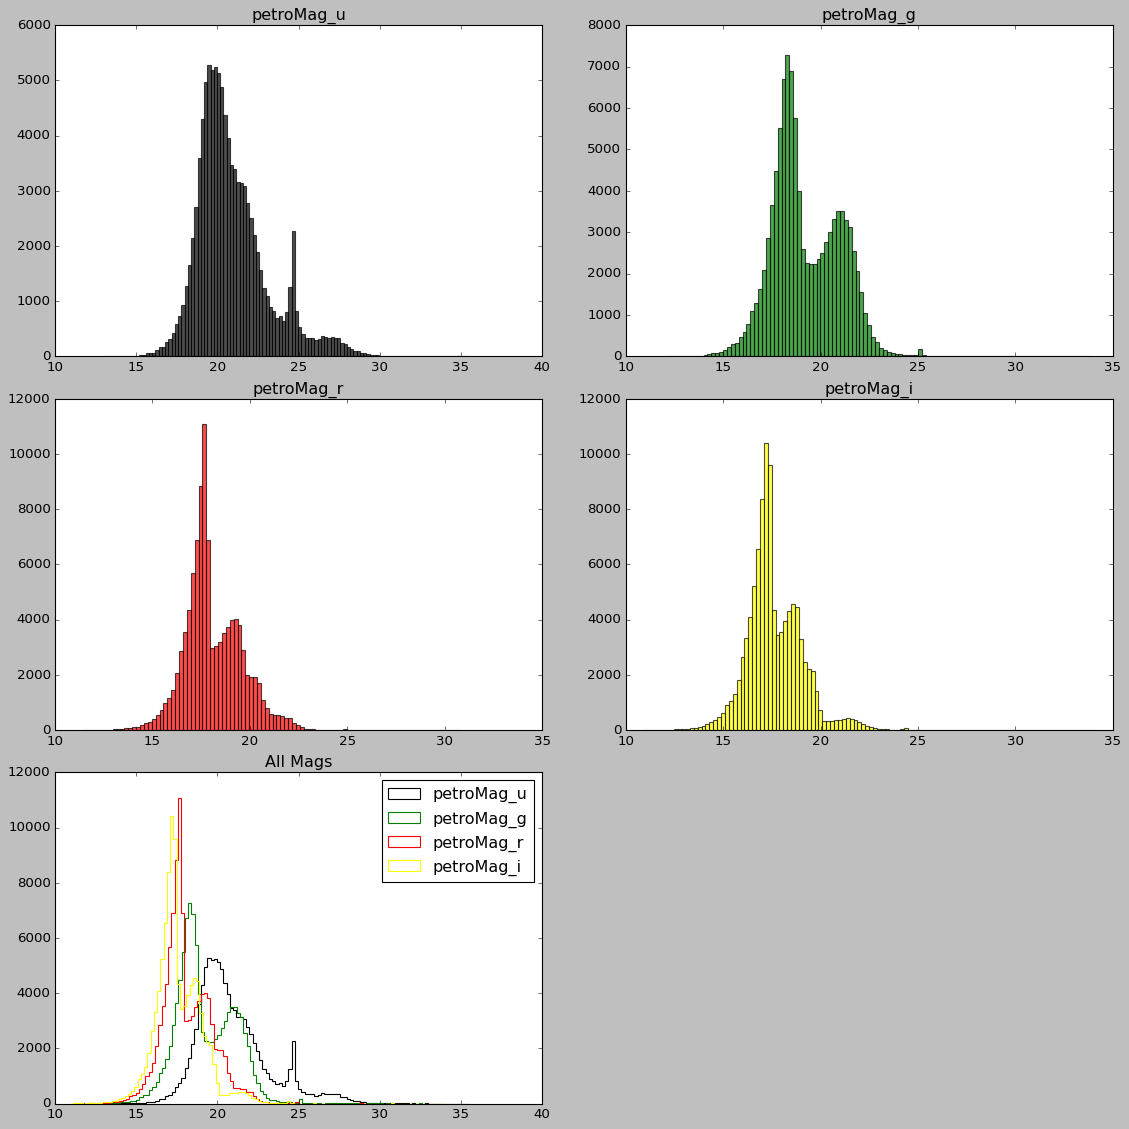

In [5]:
### MAG PLOTS

mags = ['petroMag_'+band for band in 'ugri']

key_list = mags 
color_list = ['black', 'green', 'red', 'yellow']
hor = 2
ver = 3

plt.style.use('classic')

fig = plt.figure(figsize=(14, 14), constrained_layout=True)
gs = fig.add_gridspec(ver, hor, left=0.05, right=0.5, wspace=0.05)

i=0
binsize=0.2
def binarange(arr):
    return np.arange(min(arr), max(arr)+binsize, binsize)


for v in range(ver):
    for h in range(hor):
        if v==2:
                     
            ax = fig.add_subplot(gs[v, 0])
            for c, key in enumerate(key_list):
                bins = binarange(data.field(key))
                ax.hist(data.field(key), bins=bins, color=color_list[c], alpha=1, label=key, histtype='step')
            ax.set_title("All Mags")
            plt.legend()
            
            break
            i+=1
        
        
        mags = ['petroMag_'+band for band in 'ugri']
        
        ax = fig.add_subplot(gs[v, h])
        bins = binarange(data.field(key_list[i]))
        ax.hist(data.field(key_list[i]), bins=bins, color=color_list[i], alpha=0.7)
        ax.set_title(key_list[i])
        i+=1

plt.show

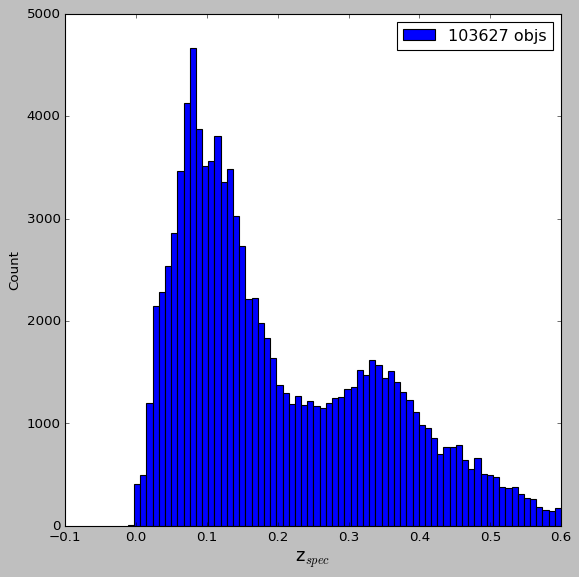

In [6]:
#ZSPEC PLOTS

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot()
ax.hist(np.array(data.field('z')), bins=70, color='blue', label=f'{len(data)} objs')
ax.set_xlabel('z$_{spec}$', fontsize=16)
ax.set_ylabel('Count')
plt.legend()

In [7]:
#preprocessing

from sklearn.preprocessing import MinMaxScaler
np.random.seed(42)

train_percentual = 7/10
train_cut = np.random.uniform(0, 1, len(data)) < train_percentual
train_data = data[train_cut]

test_val_data = data[~train_cut]

test_percentual = 2/3
test_cut = np.random.uniform(0, 1, len(test_val_data)) < test_percentual

test_data = test_val_data[test_cut]
val_data = test_val_data[~test_cut]

print(f'Train Percent = {len(train_data)/len(data)*100:.2f}%')
print(f'Test Percent = {len(test_data)/len(data)*100:.2f}%')
print(f'Val Percent = {len(val_data)/len(data)*100:.2f}%')

#embaralhando os dados

train_shuffler = np.random.choice(len(train_data), len(train_data), replace=False)
train_data = train_data[train_shuffler]

test_shuffler = np.random.choice(len(test_data), len(test_data), replace=False)
test_data = test_data[test_shuffler]

val_shuffler = np.random.choice(len(val_data), len(val_data), replace=False)
val_data = val_data[val_shuffler]


x_train = np.array([train_data.field(mag) for mag in mags]).T
y_train = np.array(train_data.field('z'))

x_test = np.array([test_data.field(mag) for mag in mags]).T
y_test = np.array(test_data.field('z'))

x_val = np.array([val_data.field(mag) for mag in mags]).T
y_val = np.array(val_data.field('z'))

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_val = scaler.transform(x_val)

np.max(x_test[:, 1])
print(train_data)

Train Percent = 70.13%
Test Percent = 19.94%
Val Percent = 9.93%
[(239.96698,  9.4248942, 0.1366006 , 2.286765e-05, 19.2582 , 0.09507193, 18.40424, 0.02028173, 17.7064 , 0.01618556, 17.39722, 0.01963972)
 (132.43307, 12.298714 , 0.05055315, 1.398644e-05, 20.34308, 0.350875  , 18.09925, 0.01583923, 17.671  , 0.02084511, 17.75408, 0.09138411)
 (179.37387, 61.61603  , 0.06413542, 8.810581e-06, 18.37456, 0.04583798, 17.29594, 0.0075871 , 16.8173 , 0.00823788, 16.4948 , 0.01054527)
 ...
 (223.17777, 22.252389 , 0.3326881 , 7.729011e-05, 20.97871, 0.8278182 , 20.5789 , 0.1542476 , 19.06299, 0.09664413, 18.37456, 0.07566027)
 (337.61987, 21.462954 , 0.3736901 , 7.758995e-05, 21.43932, 0.3494269 , 20.9861 , 0.1100968 , 19.3139 , 0.04810604, 18.60558, 0.0461115 )
 (157.70585, 29.498816 , 0.5205936 , 9.739409e-05, 26.48391, 1.413567  , 21.28289, 0.1700425 , 20.18533, 0.09028883, 19.12412, 0.06661087)]


In [8]:
import tensorflow.keras as keras
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = "0"


def build_model(input_shape, nb_classes=1):
    input_layer = keras.layers.Input(input_shape)

    layer_1 = keras.layers.Dense(512, activation='relu')(input_layer)
    layer_1= keras.layers.Dropout(rate=0.2)(layer_1)

    layer_2 = keras.layers.Dense(256, activation='relu')(layer_1)
    layer_2 = keras.layers.Dropout(rate=0.2)(layer_2)

    layer_3 = keras.layers.Dense(128, activation='relu')(layer_2)
    layer_3 = keras.layers.Dropout(rate=0.2)(layer_3)

    output_layer = keras.layers.Dense(units=nb_classes,activation='linear')(layer_2)


    model = keras.models.Model(inputs=input_layer, outputs=output_layer)
    return model

regressor = build_model(x_train.shape[1:])
regressor.compile(loss='mse', optimizer=keras.optimizers.Nadam(), metrics=['accuracy'])


batch_size = 128
epochs = 2

history = regressor.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, 
                     verbose=1, validation_data=(x_val,y_val))

preds = regressor.predict(x_test)

2021-11-09 13:31:59.158655: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-09 13:31:59.168013: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-09 13:31:59.168578: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-09 13:31:59.169578: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Epoch 1/2
568/568 [==============================] - 4s 4ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 2/2
568/568 [==============================] - 2s 4ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00


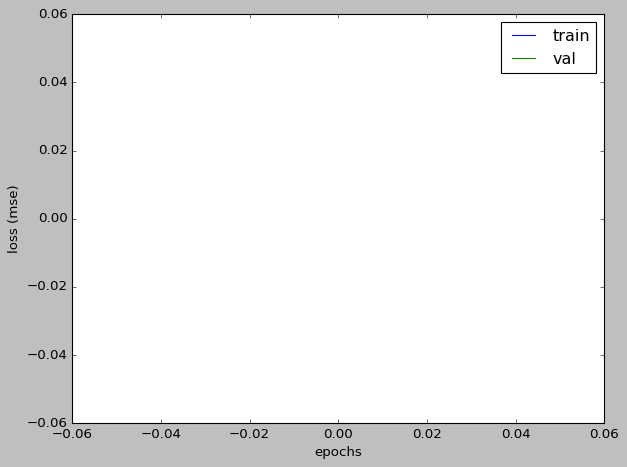

In [9]:
# TRAINING PLOTS

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(loss, label='train')
plt.plot(val_loss, label='val')
plt.xlabel('epochs')
plt.ylabel('loss (mse)')
plt.legend()
plt.tight_layout()

In [10]:
### CALCULO DAS MÉTRICAS E PLOTS
def get_zstatistic(z,zspec):
    
    deltaz=z-zspec
    mean_bias=np.mean(deltaz)


    p16=np.percentile(deltaz,15.85)
    p84=np.percentile(deltaz,84.05)
    sigma68=0.5*(p84-p16)
    median_bias=np.percentile(deltaz,50)
    return mean_bias,median_bias,sigma68
    

def redshift_plot(z, zspec):
    
    plt.style.use('default')
    
    fig = plt.figure(figsize=(10, 8))
    
    mean_bias,median_bias,sigma68=get_zstatistic(z, zspec)


    text="\n $\sigma_{68}$: $"+str(round(sigma68,3))+"$"
    text+="\n Mean Bias: $"+str(round(mean_bias,3))+"$"
    text+="\n Median Bias: $"+str(round(median_bias,3))+"$"
    ax = fig.add_subplot()
    
    #dispersão entre photo-z e spec-z
    ax.scatter(np.array(zspec), np.array(z),
                       alpha = 0.5,
                       s=8,marker='o')
    
    #reta x = y
    reta = [0, max([max(zspec), max(z)])]
    ax.plot(reta, reta,
              ls='dashed', color='black', lw=0.5)
    
    #limites e legendas
    ax.set_ylim(min(z),max(z))
    ax.set_xlim(0,max(zspec))
    ax.set_ylabel("$z_{phot}$", fontsize=15)
    ax.set_xlabel("$z_{spec}$", fontsize=15)
    ax.text(0.7*max(zspec), .2*max(z), text, va="top", fontsize=12)
    
    plt.show()


In [11]:
#preds

In [12]:
#redshift_plot(preds, y_test)
